* 请在环境变量中设置`DB_URI`指向数据库

In [1]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PyFin.api import *
from alphamind.api import *
from alphamind.strategy.strategy import Strategy, RunningSetting
from alphamind.portfolio.meanvariancebuilder import target_vol_builder

plt.style.use('ggplot')

## 1. Single Day Analysis
-----------------------

In [2]:
ref_date = '2020-01-02'
engine = SqlEngine(os.environ['DB_URI'])
universe = Universe('hs300')

In [3]:
codes = engine.fetch_codes(ref_date, universe)
total_data = engine.fetch_data(ref_date, 'EMA5D', codes, 300, industry='sw', risk_model='short')
all_styles = risk_styles + industry_styles + ['COUNTRY']

In [4]:
risk_cov = total_data['risk_cov'][all_styles].values
factor = total_data['factor']
risk_exposure = factor[all_styles].values
special_risk = factor['srisk'].values

### Portfolio Construction

* using `EPS` factor as alpha factor;
* short selling is forbiden;
* target of volatility for the activate weight is setting at 2.5% annually level.

In [5]:
er = factor['EMA5D'].fillna(factor["EMA5D"].median()).values
bm = factor['weight'].values
lbound = np.zeros(len(er))
ubound = bm + 0.01
cons_mat = np.ones((len(er), 1))
risk_targets = (bm.sum(), bm.sum())
target_vol = 0.025
risk_model = dict(cov=None, factor_cov=risk_cov/10000, factor_loading=risk_exposure, idsync=special_risk ** 2 / 10000.)

status, p_er, p_weight = \
    target_vol_builder(er, risk_model, bm, lbound, ubound, cons_mat, risk_targets, target_vol)
    
sec_cov = risk_exposure @ risk_cov @ risk_exposure.T / 10000. + np.diag(special_risk ** 2) / 10000

In [6]:
# check the result
print(f"total weight is {p_weight.sum(): .4f}")
print(f"portfolio activate weight forecasting vol is {np.sqrt((p_weight - bm) @ sec_cov @ (p_weight - bm)):.4f}")
print(f"portfolio er: {p_weight @ er:.4f} comparing with benchmark er: {bm @ er:.4f}")

total weight is  1.0007
portfolio activate weight forecasting vol is 0.0250
portfolio er: 124.8849 comparing with benchmark er: 81.8985


## 2. Porfolio Construction: 2016 ~ 2018
-------------------------------

In [7]:
"""
Back test parameter settings
"""

start_date = '2020-01-01'
end_date = '2020-02-21'

freq = '10b'
neutralized_risk = industry_styles
industry_name = 'sw'
industry_level = 1
risk_model = 'short'
batch = 0
horizon = map_freq(freq)
universe = Universe('hs300')
data_source = os.environ['DB_URI']
benchmark_code = 300
target_vol = 0.05
weights_bandwidth = 0.02

In [8]:
"""
Factor Model
"""

alpha_factors = {'f01': CSRank(LAST('EMA5D'))}
weights = dict(f01=1.)
alpha_model = ConstLinearModel(features=alpha_factors, weights=weights)

data_meta = DataMeta(freq=freq,
                         universe=universe,
                         batch=batch,
                         neutralized_risk=neutralized_risk,
                         risk_model='short',
                         pre_process=[winsorize_normal, standardize],
                         post_process=[standardize],
                         warm_start=0,
                         data_source=data_source)

In [9]:
"""
Constraintes settings
"""

constraint_risk = ['SIZE', 'SIZENL', 'BETA']
total_risk_names = constraint_risk + ['benchmark', 'total']

b_type = []
l_val = []
u_val = []

previous_pos = pd.DataFrame()
rets = []
turn_overs = []
leverags = []

for name in total_risk_names:
    if name == 'benchmark':
        b_type.append(BoundaryType.RELATIVE)
        l_val.append(0.8)
        u_val.append(1.0)
    else:
        b_type.append(BoundaryType.ABSOLUTE)
        l_val.append(0.0)
        u_val.append(0.0)

bounds = create_box_bounds(total_risk_names, b_type, l_val, u_val)

In [10]:
"""
Running Settings
"""
running_setting = RunningSetting(weights_bandwidth=weights_bandwidth,
                                 rebalance_method='tv',
                                 bounds=bounds,
                                 target_vol=target_vol)

In [11]:
"""
Strategy run
"""
strategy = Strategy(alpha_model,
                    data_meta,
                    universe=universe,
                    start_date=start_date,
                    end_date=end_date,
                    freq=freq,
                    benchmark=benchmark_code)
strategy.prepare_backtest_data()
ret_df, positions = strategy.run(running_setting)

2021-07-03 11:34:44,202 - ALPHA_MIND - INFO - alpha factor data loading finished ...
2021-07-03 11:34:44,457 - ALPHA_MIND - INFO - industry data loading finished ...
2021-07-03 11:34:44,911 - ALPHA_MIND - INFO - benchmark data loading finished ...
2021-07-03 11:34:45,587 - ALPHA_MIND - INFO - risk_model data loading finished ...
2021-07-03 11:34:46,408 - ALPHA_MIND - INFO - returns data loading finished ...
2021-07-03 11:34:46,492 - ALPHA_MIND - INFO - starting backting ...
2021-07-03 11:34:46,499 - ALPHA_MIND - INFO - alpha models training finished ...
2021-07-03 11:34:46,596 - ALPHA_MIND - INFO - 2020-01-02 00:00:00 re-balance: 300 codes
2021-07-03 11:34:46,661 - ALPHA_MIND - INFO - 2020-01-16 00:00:00 re-balance: 300 codes
2021-07-03 11:34:46,738 - ALPHA_MIND - INFO - 2020-02-07 00:00:00 re-balance: 300 codes
2021-07-03 11:34:46,862 - ALPHA_MIND - INFO - 2020-02-21 00:00:00 re-balance: 300 codes


<AxesSubplot:title={'center':'Fixed freq rebalanced with target vol                                                      at 0.05: 10b with benchmark 300'}>

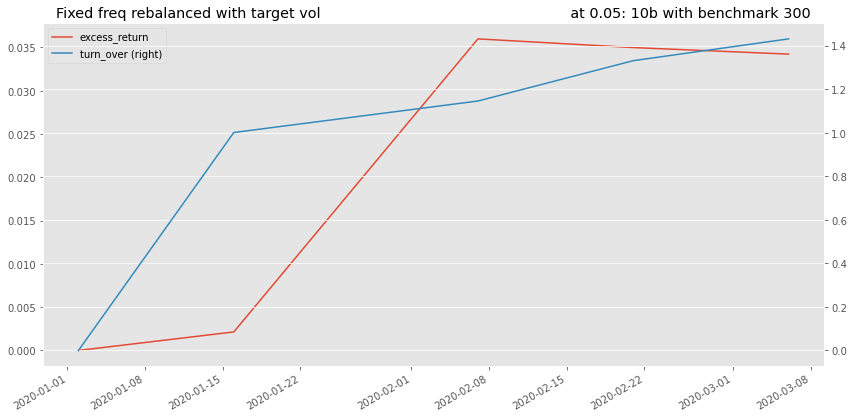

In [12]:
ret_df[['excess_return', 'turn_over']].cumsum().plot(figsize=(14, 7),
                                                     title='Fixed freq rebalanced with target vol \
                                                     at {2}: {0} with benchmark {1}'.format(freq, benchmark_code, target_vol),
                                                     secondary_y='turn_over')